In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pulse2percept.datasets import load_perezfornos2012
import time
from pulse2percept.models import TemporalModel
from pulse2percept.stimuli.pulse_trains import BiphasicPulseTrain
from scipy.optimize import minimize, differential_evolution
from datetime import datetime
import pandas as pd

In [2]:
data = load_perezfornos2012()

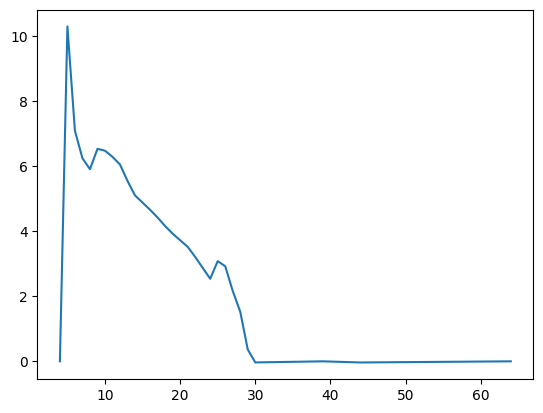

In [3]:
plt.plot(data['time_series'][0])

## test

In [11]:
# fixed parameters
SigmaX=.4 # phosphene dimension in x axis
SigmaY=.4 # phosphene dimension in y axis
X0=24  # distance between two adjecent phosphenes in x axis
Y0=24  # distance between two adjecent phosphenes in y axis
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

va = 0
vb = 0.333
vc = 0.667
vd = 1
MMr = 6  # number of rows
MMc = 10  # number of columns;
C = 240  # number of pixel columns
R = 144 # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24
v2 = 0
v3 = 0
count = 0

# fit parameters
DFR=60 # display frame rate (usually 30 or 60 FPS)
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
brightness_scale = 10

# fixed parameters - condition dependent
EAR=6  # electrode activation rate (usually 6 or 10 Hz)
exper_dur = 60  # experiment duration
stim_dur = 10  # stimulus duration

In [6]:
PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
PF_Factor = PFO*EAR

# Creating meshgrid
x = np.arange(0, C)  # in Python, np.arange() starts from 1 to C inclusive
y = np.arange(0, R)  # in Python, np.arange() starts from 1 to R inclusive
X, Y = np.meshgrid(x, y)
# Initialization
z = np.zeros((R, C))
Frame = np.zeros((R, C))
FormerFrame = np.zeros((R, C))
PFC = np.zeros((MMr, MMc))
Theta = np.zeros((MMr, MMc))
a = np.zeros((MMr, MMc))
b = np.zeros((MMr, MMc))
c = np.zeros((MMr, MMc))
sigma_x = np.zeros((MMr, MMc))
sigma_y = np.zeros((MMr, MMc))

count = 0
for s in range(MMr):
    for t in range(MMc):
        Theta[s, t] = 0
        sigma_x[s, t] = SigmaX
        sigma_y[s, t] = SigmaY
        a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                  (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
        b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                   (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
        c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                  (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)


In [4]:
I_frame = [1]*(stim_dur)*MMr*MMc  # the brightness of the video is always 1
I_frame_0 = [0]*(exper_dur-stim_dur)*MMr*MMc  # no visual input after 30s
I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
I_frame = np.array(I_frame).reshape(exper_dur, MMr, MMc)

results = []

for frame in range(exper_dur):
    I = I_frame[frame]
    # I = I / I.max()
    MeanMatrix = np.zeros((MMr, MMc))
    s = 0
    t = 0
    v = 0

    start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
    stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
    step = -int(np.floor(I.shape[0] / MMr))
    for m in range(start, stop, step):
        for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
            for j in range(m, m - (I.shape[0] // MMr), -1):
                # for k in range(n, n + (I.shape[1] // MMc)-2):
                for k in range(n, n - (I.shape[1] // MMc), -1):
                    v += I[j, k]
            v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

            if 0 <= v <= 0.25:
                v = va
            elif 0.25 < v <= 0.5:
                v = vb
            elif 0.5 < v <= 0.75:
                v = vc
            else:
                v = vd
            MeanMatrix[s, t] = v
            v = 0
            t += 1
        t = 0
        s += 1

    getting_all_subframe = []
    for SubFrame in range(1, DFR // EAR + 1):
        for s in range(MMr):
            for t in range(MMc):
                adjusted_t = t + 1
                adjusted_s = s + 1
                z += MeanMatrix[s, t] * np.exp(
                    # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                    -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                    # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                    (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                    # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                    2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                    # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                    c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

            v2 -= (X0 / 2) * v3
            v3 *= -1

        for s in range(R, 0, -X0):
            for t in range(0, C, Y0):
                if SubFrame == 1:
                    condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                    condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                    condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                    condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                    if condition1 or condition2 or condition3 and condition4:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        # Frame(s-X0+1:s,t:t+Y0-1) = exp(-PER_Factor)*FormerFrame(s-X0+1:s,t:t+Y0-1);
                    elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                        PFC[s//X0-1, t//Y0] += 1
                        # elseif mean(mean(z(s-X0+1:s,t:t+Y0-1))) >= mean(mean(FormerFrame(s-X0+1:s,t:t+Y0-1)))...
                            # && PFC(s/X0,floor(t/Y0)+1) < PF_Factor%*(1+(2/5)*(rand-0.5))
                        # Frame(s-X0+1:s,t:t+Y0-1) = z(s-X0+1:s,t:t+Y0-1) ;
                        # PFC(s/X0,floor(t/Y0)+1) = PFC(s/X0,floor(t/Y0)+1) + 1;
                    elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        # elseif PFC(s/X0,floor(t/Y0)+1) >= PF_Factor%*(1+(2/5)*(rand-0.5))
                        # Frame(s-X0+1:s,t:t+Y0-1) = exp(-3*PER_Factor)*FormerFrame(s-X0+1:s,t:t+Y0-1);
                else:
                    Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
                    # Frame(s-X0+1:s,t:t+Y0-1) = exp(-PER_Factor)*Frame(s-X0+1:s,t:t+Y0-1);
        z = np.zeros((R,C))
        count = count + 1

        FormerFrame = Frame
        getting_all_subframe.append(Frame.max())
    results.append(max(getting_all_subframe))

output =  [x * brightness_scale for x in results]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: ignored

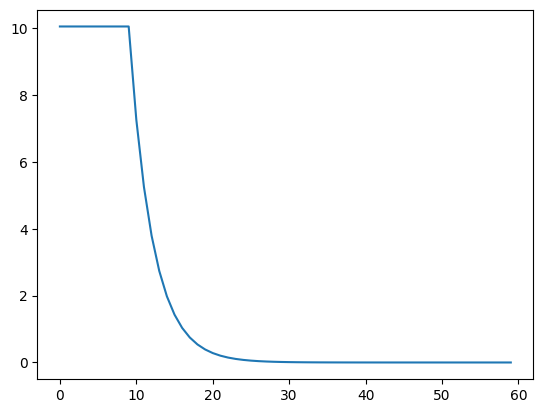

In [ ]:
plt.plot(output)

## train

In [4]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [7]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    # fixed parameters
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    # X0=24  # distance between two adjecent phosphenes in x axis
    # Y0=24  # distance between two adjecent phosphenes in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1
    # MMr = 6  # number of rows
    # MMc = 10  # number of columns;
    # C = 240  # number of pixel columns
    # R = 144 # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 3  # number of rows
    MMc = 3  # number of columns;
    X0 = 24  # distance between two adjecent phosphenes in x axis
    Y0 = 24  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_


In [ ]:
import numpy as np
from scipy.optimize import minimize

def objective_function(params, gt_curves_train):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    
    total_mse = 0
    y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
    for y in gt_curves_train: total_mse += np.mean((np.array(y_predicted) - y) ** 2)
        
    print(total_mse/len(gt_curves_train))
    
    return total_mse/len(gt_curves_train)


for cond in range(5):
    for subj in range(9):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

        i = cond*9 + subj

        if i < -1 : pass
        else:
            idx_lst = list(range(cond*9 , (cond+1)*9))
            idx_lst.remove(i)
            
            if i <= 8: 
                args.EAR = 20
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 17: 
                args.EAR = 5
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 26:
                args.EAR = 60
                args.exper_dur = 30
                args.stim_dur = 10
                
            elif i<=35: 
                args.EAR = 20
                args.exper_dur = 10
                args.stim_dur = 1
            else: 
                args.EAR = 20
                args.exper_dur = 70
                args.stim_dur = 60
                
            # curve = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur+4]
            # ground_truth = curve  
            
            gt_curves_train = [np.nan_to_num(data['time_series'][idx], 0)[4:args.exper_dur*args.interpolation_factor+4] for idx in idx_lst]
            gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]
    
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_train,), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)
            
            file_path = '/hdd/yuchen/baseline_test.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

16.665262813204272
16.649918736301764
16.665262813204272
16.665262813204272
18.631186984616832
14.866599225286562
13.247414935153206
14.86006852571736
14.022652993910059
12.84824718701267
11.271065577854198
10.595374800700796
8.592808346878016
9.039271896300228
7.873569559574173
6.687582358212859
6.574233479279936
7.608117277835066
6.752621897543099
7.23188595769689
9.731095130172521
6.956864164281352
7.940042044899651
6.66704588010327
7.091544989032545
6.64787801418831
6.982328325091998
6.591592929209027
6.681205835584983
6.590979511903934
6.699400561482604
6.583672659297158
6.738530820169475
6.57428148123984
6.562161922163449
6.604668825986212
6.643938932566076
6.5600715187830865
6.641921547722248
6.558838648343286
6.539893933584759
6.530995693407894
6.580191717081288
6.553278236889918
6.571219134511811
6.549974802855793
6.540737411008406
6.533769074494147
6.5185262411541185
6.504587110149184
6.497433687176507
6.474115708508002
6.484467589487195
6.506095785209532
6.447579660610118
6.

## train per panel 0.5 interp

In [5]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [6]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 3  # number of rows
    MMc = 3  # number of columns;
    X0 = 24  # distance between two adjecent phosphenes in x axis
    Y0 = 24  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_


In [ ]:
import numpy as np
from scipy.optimize import minimize

def objective_function(params, gt_curves_val):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    
    total_mse = 0
    y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
    mse = np.mean((np.array(y_predicted) - gt_curves_val) ** 2)
    print(mse)
    return mse


for cond in range(5):
    for subj in range(9):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

        i = cond*9 + subj

        if i < -1 : pass
        else:
            idx_lst = list(range(cond*9 , (cond+1)*9))
            idx_lst.remove(i)
            
            if i <= 8: 
                args.EAR = 20
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 17: 
                args.EAR = 5
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 26:
                args.EAR = 60
                args.exper_dur = 30
                args.stim_dur = 10
                
            elif i<=35: 
                args.EAR = 20
                args.exper_dur = 10
                args.stim_dur = 1
            else: 
                args.EAR = 20
                args.exper_dur = 70
                args.stim_dur = 60
                
            gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]
    
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_val,), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)
            
            file_path = '/hdd/yuchen/baseline_perpanel.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

10.346555878456137
10.359148559207568
10.346555878456137
10.346555878456137
12.197608919148918
8.676053251013093
7.177321557923012
8.667052633087678
7.900980643257232
6.8267361949431296
5.401097231908988
4.7718710566853515
3.0085689662140385
3.400808096377512
2.4080175249940408
1.5394836638454623
1.5253914380873028
3.030788954802703
1.8923876550332357
2.538517807779082
5.3833092578012165
1.7024903573253842
2.4661571694564244
1.7480611590276605
2.7913355389208205
1.5506249081341494
1.6105544554941267
1.873017101306199
1.5508796898684871
1.641576980106052
1.540025518251135
1.5866190353073624
1.5254313437283373
1.5658473378717412
1.526968948096904
1.5534908299446604
1.5245037180747305
1.5672029081383665
1.5234208468494161
1.5346614704578985
1.5223087658422183
1.529147758055205
1.5223165952922024
1.5178494689198432
1.5159859128849342
1.5268662465314018
1.5205093739208586
1.5214980726348715
1.5178586221584638
1.5130810419708542
1.5096599989493766
1.5132050934037233
1.5069525539327013
1.5040

## train per panel 0.25 interp

In [6]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 4 # number of frames sampled every second
    
args = Args()

In [10]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_


In [11]:
import pandas as pd
data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')  

In [12]:
import numpy as np
from scipy.optimize import minimize

args.interpolation_factor = 4

def objective_function(params, gt_curves_val):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    
    total_mse = 0
    y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
    mse = np.mean((np.array(y_predicted) - gt_curves_val) ** 2)
    print(mse)
    return mse


for cond in range(5):
    for subj in range(9):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

        i = cond*9 + subj

        if i < -1 : pass
        else:
            idx_lst = list(range(cond*9 , (cond+1)*9))
            idx_lst.remove(i)
            
            if i <= 8: 
                args.EAR = 20
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 17: 
                args.EAR = 5
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 26:
                args.EAR = 60
                args.exper_dur = 30
                args.stim_dur = 10
                
            elif i<=35: 
                args.EAR = 20
                args.exper_dur = 10
                args.stim_dur = 1
            else: 
                args.EAR = 20
                args.exper_dur = 70
                args.stim_dur = 60
                
            # gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:args.exper_dur*args.interpolation_factor+4]
            gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0)  
            
    
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_val,), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)
            
            file_path = '/hdd/yuchen/baseline_perpanel-025interp.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

10.056183213059173
10.068090891464434
10.056183213059173
10.056183213059173
11.9183127466258
8.374525723548066
6.865127792039355
8.366388244668519
7.594461788271696
6.512378275160491
5.075273234410743
4.44044565204253
2.658229719803286
3.0548044781919352
2.0487236469652284
1.156888690274318
1.1382722915362193
2.612976744709004
1.4893956433190851
2.1259353476478484
4.94865539343817
1.3279494323334544
2.107657644426654
1.3749057599795436
2.4379787688721213
1.1591074650487498
1.216107781733089
1.470494792243594
1.1690192728693523
1.264723006495826
1.1498595107960456
1.1928849956740575
1.1405435880989643
1.1850769809156712
1.1380893544981654
1.1921491800386894
1.1371742562149314
1.1563775995767442
1.1379323811502635
1.1461823378757283
1.1357799916327618
1.1301383364400264
1.126341288323699
1.1395956321486331
1.133630975704236
1.1357365339016583
1.1287583743098668
1.1232537668421985
1.1185712515563528
1.1396569040865157
1.1283287553336243
1.1178877448889557
1.1128557735949978
1.115211065598

## train per-condition 0.5 interp

In [5]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [14]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [8]:
stim_info = {}
# EAR, exper_dur, stim_dur
for i in range(9): stim_info[i] = [20, 30, 10]
for i in range(9,18): stim_info[i] = [5, 30, 10]
for i in range(18,27): stim_info[i] = [60, 30, 10]
for i in range(27,36): stim_info[i] = [20, 10, 1]
for i in range(36,45): stim_info[i] = [20, 70, 60]

In [ ]:
import numpy as np
from scipy.optimize import minimize

args.interpolation_factor = 2

def objective_function(params, gt_curves_train, stim_lst):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    
    total_mse = 0
    for gt_idx in range(len(gt_curves_train)):
        gt_y = gt_curves_train[gt_idx]
        stim = stim_lst[gt_idx]

        args.EAR = stim[0]
        args.exper_dur = stim[1]
        args.stim_dur = stim[2]

        y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
        total_mse += np.mean((np.array(y_predicted) - gt_y) ** 2)
    print(total_mse/4)
    return total_mse/4

for subj in range(9):
    for cond in range(5):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

        i = cond*9 + subj

        if i < -1 : pass
        else:
            idx_lst = [0*9+subj, 1*9+subj, 2*9+subj, 3*9+subj, 4*9+subj]
            idx_lst.remove(i)
            
            args.EAR = stim_info[i][0]
            args.exper_dur = stim_info[i][1]
            args.stim_dur = stim_info[i][2]

            gt_curves_val = np.nan_to_num(data['time_series'][i], 0)[4:stim_info[i][1]*args.interpolation_factor+4]
            gt_curves_train = [np.nan_to_num(data['time_series'][idx], 0)[4:stim_info[idx][1]*args.interpolation_factor+4] for idx in idx_lst] 
            stim_lst = [stim_info[idx] for idx in idx_lst]
            
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_train,stim_lst), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)
            
            file_path = '/hdd/yuchen/baseline_percondition.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

11.207451247281632
11.105032084702513
11.414154623802121
11.219741003251855
12.355300775946278
10.24865081576471
9.410101731738447
10.047427514088854
9.653276474509592
8.997278526265582
8.173333302497866
7.965989351287076
7.242577894049734
7.41387509722754
7.113133289176096
7.389226196779159
7.089393205874161
8.587634070433914
7.610337680306793
7.1434055452764635
7.3611531519883675
7.11787127333557
7.6244149190037405
7.066449632240914
6.975245783413377
6.968352687277872
7.111098280354012
6.875932242958759
6.8655041917027635
7.111287087240203
6.973615916139638
7.283025782125114
6.954330545929229
6.819414091248554
6.752537831379767
6.837089274482857
6.9985533179212664
6.8678754349794096
6.7551861270975975
6.843149592363412
6.754088563749555
6.749259750799756
6.7638220989416045
6.63967834789536
6.586750729823869
6.596446339535674
6.668135449611966
6.558145126609904
6.55232440307468
6.483320805408191
6.478903876638526
6.482404530505718
6.730972819759066
6.50806231382214
6.462476483660295
6

## train per-condition 0.25 interp

In [15]:
# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [17]:
import pandas as pd
data = pd.read_csv('perez-fornos-2012.csv')  

In [18]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [19]:
stim_info = {}
# EAR, exper_dur, stim_dur
for i in range(9): stim_info[i] = [20, 30, 10]
for i in range(9,18): stim_info[i] = [5, 30, 10]
for i in range(18,27): stim_info[i] = [60, 30, 10]
for i in range(27,36): stim_info[i] = [20, 10, 1]
for i in range(36,45): stim_info[i] = [20, 70, 60]

In [26]:
import numpy as np
from scipy.optimize import minimize

args.interpolation_factor = 4

def objective_function(params, gt_curves_train, stim_lst):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    
    total_mse = 0
    for gt_idx in range(len(gt_curves_train)):
        gt_y = gt_curves_train[gt_idx]
        stim = stim_lst[gt_idx]

        args.EAR = stim[0]
        args.exper_dur = stim[1]
        args.stim_dur = stim[2]

        y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
        total_mse += np.mean((np.array(y_predicted) - gt_y) ** 2)
    # print(total_mse/4)
    return total_mse/4

for subj in range(0, 9):
    for cond in range(5):

        i = cond*9 + subj
        print(i)

        if i != 22 : pass
        else:
            idx_lst = [0*9+subj, 1*9+subj, 2*9+subj, 3*9+subj, 4*9+subj]
            idx_lst.remove(i)
            
            args.EAR = stim_info[i][0]
            args.exper_dur = stim_info[i][1]
            args.stim_dur = stim_info[i][2]

            gt_curves_train = [np.nan_to_num(data.iloc[idx, 6:stim_info[idx][1]*args.interpolation_factor+6].to_numpy().astype('float64'), 0) for idx in idx_lst] 
            gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0)  

            stim_lst = [stim_info[idx] for idx in idx_lst]
            
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_train,stim_lst), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)

            current_time = datetime.now()
            formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
        
            
            file_path = 'baseline_percondition_025interp.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

0
9
18
27
36
1
10
19
28
37
2
11
20
29
38
3
12
21
30
39
4
13
22
Optimized Parameters: [3.   2.8  2.94 6.52]
31
40
5
14
23
32
41
6
15
24
33
42
7
16
25
34
43
8
17
26
35
44


## train per-subject 0.25 interp

In [6]:
import pandas as pd
data = pd.read_csv('perez-fornos-2012.csv')  

# fixed parameters - condition dependent
class Args():
    EAR = 20 # electrode activation rate 
    exper_dur = 30 # experiment duration
    stim_dur = 10 # stimulus duration
    interpolation_factor = 2 # number of frames sampled every second
    
args = Args()

In [7]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 2  # number of rows
    MMc = 3  # number of columns;
    X0 = 20  # distance between two adjecent phosphenes in x axis
    Y0 = 20  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [8]:
stim_info = {}
# EAR, exper_dur, stim_dur
for i in range(9): stim_info[i] = [20, 30, 10]
for i in range(9,18): stim_info[i] = [5, 30, 10]
for i in range(18,27): stim_info[i] = [60, 30, 10]
for i in range(27,36): stim_info[i] = [20, 10, 1]
for i in range(36,45): stim_info[i] = [20, 70, 60]

In [14]:
import numpy as np
from scipy.optimize import minimize

args.interpolation_factor = 4

def objective_function(params, gt_curves_train, stim_lst):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
    
    
    total_mse = 0
    for gt_idx in range(len(gt_curves_train)):
        gt_y = gt_curves_train[gt_idx]
        # stim = stim_lst[gt_idx]
        # args.EAR = stim[0]
        # args.exper_dur = stim[1]
        # args.stim_dur = stim[2]

        total_mse += np.mean((np.array(y_predicted) - gt_y) ** 2)
    # print(total_mse/len(gt_curves_train))
    return total_mse/len(gt_curves_train)

for subj in range(9):
    for cond in range(5):

        i = cond*9 + subj
        print(i)

        if i in [0,9,18,27] : pass
        else:
            idx_lst = [cond*9 + sub for sub in range(9)]
            idx_lst.remove(i)
            
            args.EAR = stim_info[i][0]
            args.exper_dur = stim_info[i][1]
            args.stim_dur = stim_info[i][2]

            gt_curves_train = [np.nan_to_num(data.iloc[idx, 6:stim_info[idx][1]*args.interpolation_factor+6].to_numpy().astype('float64'), 0) for idx in idx_lst] 
            gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0)  

            stim_lst = [stim_info[idx] for idx in idx_lst]
            
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_train,stim_lst), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)

            current_time = datetime.now()
            formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
            
            file_path = 'baseline_persubject_025interp.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

0
9
18
27
36
Optimized Parameters: [ 0.28  4.25 76.47  4.29]
1
Optimized Parameters: [7.44 5.24 8.48 5.17]
10
Optimized Parameters: [ 9.09 10.08 45.24  4.83]
19
Optimized Parameters: [ 24.69  18.98 -51.8    3.84]
28
Optimized Parameters: [ 7.4   0.25 -3.51  4.83]
37
Optimized Parameters: [13.38  1.05 51.52  5.46]
2
Optimized Parameters: [ 8.31  6.59 -9.74  4.47]
11
Optimized Parameters: [22.3   6.4   7.92  5.15]
20
Optimized Parameters: [ 31.78  18.71 -61.2    3.5 ]
29
Optimized Parameters: [ 7.33  0.3  -1.69  4.27]
38
Optimized Parameters: [ 0.6   1.53 40.58  5.46]
3
Optimized Parameters: [ 8.87  0.21 -7.23  4.45]
12
Optimized Parameters: [ 11.05  28.59 -12.76   4.31]
21
Optimized Parameters: [ 28.14   6.75 -20.81   3.65]
30
Optimized Parameters: [ 7.66  1.03 25.93  4.19]
39
Optimized Parameters: [ 0.7   7.9  32.25  4.12]
4
Optimized Parameters: [7.8  4.98 0.66 4.65]
13
Optimized Parameters: [ 10.03  28.71 -12.65   4.3 ]
22
Optimized Parameters: [ 31.28  11.96 -61.36   3.69]
31
Optimi

## train 0.25s

In [14]:
data = pd.read_csv('/hdd/yuchen/perez-fornos-2012.csv')

In [15]:
# fit parameters
PER=2 # persistence duration (usually between 0 and 8 seconds)
PFO=10  # perceptual fading onset (usually between 0 and 10 seconds)
PFD=10 # perceptual fading duration (usually between 0.5 and 60 seconds)
brightness_scale = 10

def brightness_equ(PER, PFO, PFD, brightness_scale):
    # fixed parameters
    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    # X0=24  # distance between two adjecent phosphenes in x axis
    # Y0=24  # distance between two adjecent phosphenes in y axis
    ElectrodeArraySize=1 # number of electrodes (60(val=1), 256(2), 961(3), or 2916(4) electrodes)
    ElectrodeArrayStructure=1 # electrode array structure (square(val = 1) or hexagonal(2)).

    va = 0
    vb = 0.333
    vc = 0.667
    vd = 1
    # MMr = 6  # number of rows
    # MMc = 10  # number of columns;
    # C = 240  # number of pixel columns
    # R = 144 # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    SigmaX=.4 # phosphene dimension in x axis
    SigmaY=.4 # phosphene dimension in y axis
    MMr = 3  # number of rows
    MMc = 3  # number of columns;
    X0 = 24  # distance between two adjecent phosphenes in x axis
    Y0 = 24  # distance between two adjecent phosphenes in y axis
    C = MMc*Y0  # number of pixel columns
    R = MMr*X0  # number of pixel rows, choose: phosphene size 0.4; X0 and Y0 = 24

    DFR = 30 # display frame rate (usually 30 or 60 FPS)

    v2 = 0
    v3 = 0
    count = 0

    EAR = args.EAR  # electrode activation rate (usually 6 or 10 Hz)
    exper_dur = args.exper_dur  # experiment duration
    stim_dur = args.stim_dur  # stimulus duration

    PER_Factor = 3.9/(PER*DFR) # 3.9 was set for 2 precent threshold, i.e. the phosphene falls to 2 precent of its original intensity;
    PF_Factor = PFO*EAR
    PFD_Factor = 3.9/(PFD*DFR)

    # Creating meshgrid
    x = np.arange(0, C) 
    y = np.arange(0, R)  
    X, Y = np.meshgrid(x, y)
    # Initialization
    z = np.zeros((R, C))
    Frame = np.zeros((R, C))
    FormerFrame = np.zeros((R, C))
    PFC = np.zeros((MMr, MMc))
    Theta = np.zeros((MMr, MMc))
    a = np.zeros((MMr, MMc))
    b = np.zeros((MMr, MMc))
    c = np.zeros((MMr, MMc))
    sigma_x = np.zeros((MMr, MMc))
    sigma_y = np.zeros((MMr, MMc))

    count = 0
    for s in range(MMr):
        for t in range(MMc):
            Theta[s, t] = 0
            sigma_x[s, t] = SigmaX
            sigma_y[s, t] = SigmaY
            a[s, t] = (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)
            b[s, t] = -(np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_x[s, t]**2) + \
                      (np.sin(np.deg2rad(2 * Theta[s, t]))) / (4 * sigma_y[s, t]**2)
            c[s, t] = (np.sin(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_x[s, t]**2) + \
                      (np.cos(np.deg2rad(Theta[s, t]))**2) / (2 * sigma_y[s, t]**2)

    I_frame = [1]*(args.stim_dur*args.EAR)*MMr*MMc  # the brightness of the video is always 1
    # video frame rate is the same as the electrode firing rate
    
    I_frame_0 = [0]*(args.exper_dur*args.EAR-args.stim_dur*args.EAR)*MMr*MMc  # no visual input after stim_dur
    I_frame = np.append(np.array(I_frame), np.array(I_frame_0))
    I_frame = np.array(I_frame).reshape(args.exper_dur*args.EAR, MMr, MMc)

    results = []

    for frame in range(exper_dur*args.EAR):
        I = I_frame[frame]
        # I = I / I.max()
        MeanMatrix = np.zeros((MMr, MMc))
        s = 0
        t = 0
        v = 0

        start = int(np.floor((I.shape[0] % MMr) / 2) + np.floor(I.shape[0] / MMr) * MMr) - 1
        stop = int(1 + np.floor((I.shape[0] % MMr) / 2)) - 1
        step = -int(np.floor(I.shape[0] / MMr))
        for m in range(start, stop, step):
            for n in range(0, I.shape[1]//MMc*MMc - 1, I.shape[1] // MMc):
                for j in range(m, m - (I.shape[0] // MMr), -1):
                    # for k in range(n, n + (I.shape[1] // MMc)-2):
                    for k in range(n, n - (I.shape[1] // MMc), -1):
                        v += I[j, k]
                v /= ((I.shape[0] // MMr) * (I.shape[1] // MMc))

                if 0 <= v <= 0.25:
                    v = va
                elif 0.25 < v <= 0.5:
                    v = vb
                elif 0.5 < v <= 0.75:
                    v = vc
                else:
                    v = vd
                MeanMatrix[s, t] = v
                v = 0
                t += 1
            t = 0
            s += 1

        getting_all_subframe = []

        SubFrame_range = int(DFR) // int(EAR) + 1
        if SubFrame_range <= 2: SubFrame_range = 2
        for SubFrame in range(1, SubFrame_range):
            for s in range(MMr):
                for t in range(MMc):
                    adjusted_t = t + 1
                    adjusted_s = s + 1
                    z += MeanMatrix[s, t] * np.exp(
                        # -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        -0.015 * (1 / (3 * MeanMatrix[s, t] + 1)) *
                        # (a[s, t] * (X - X0 * t - v2 + X0 // 2) ** 2 +
                        (a[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) ** 2 +
                        # 2 * b[s, t] * (X - X0 * t - v2 + X0 // 2) * (Y - Y0 * s + Y0 // 2) +
                        2 * b[s, t] * (X - X0 * adjusted_t - v2 + X0 // 2) * (Y - Y0 * adjusted_s + Y0 // 2) +
                        # c[s, t] * (Y - Y0 * s + Y0 // 2) ** 2))
                        c[s, t] * (Y - Y0 * adjusted_s + Y0 // 2) ** 2))

                v2 -= (X0 / 2) * v3
                v3 *= -1

            for s in range(R, 0, -X0):
                for t in range(0, C, Y0):
                    if SubFrame == 1:
                        condition1 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) == 0 and np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) == 0)
                        condition2 = (np.mean(z[s-X0:s-1, t-1:t+Y0-2]) < np.mean(FormerFrame[s-X0:s-1, t:t+Y0-2]))
                        condition3 = (MeanMatrix[int(s/X0)-1, t // Y0] == 0)
                        condition4 = (PFC[int(s/X0)-1, t // Y0] < PF_Factor)
                        if condition1 or condition2 or condition3 and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                        elif np.mean(z[s-X0:s-1, t-1:t+Y0-2]) >= np.mean(FormerFrame[s-X0:s-1, t-1:t+Y0-2]) and condition4:
                            Frame[s-X0:s-1, t-1:t+Y0-2] = z[s-X0:s-1, t-1:t+Y0-2]
                            PFC[s//X0-1, t//Y0] += 1
                        elif PFC[s//X0-1, t//Y0] >= PF_Factor:
                            # Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-3 * PER_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                            Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PFD_Factor) * FormerFrame[s-X0:s-1, t-1:t+Y0-2]
                    else:
                        Frame[s-X0:s-1, t-1:t+Y0-2] = np.exp(-PER_Factor) * Frame[s-X0:s-1, t-1:t+Y0-2]
            z = np.zeros((R,C))
            count = count + 1

            FormerFrame = Frame
            getting_all_subframe.append(Frame.max())
        results.append(max(getting_all_subframe))

    output =  [x * brightness_scale for x in results]

    output_ = []
    combined_frame = args.EAR/args.interpolation_factor
    for i in range(args.exper_dur*args.interpolation_factor):
        output_.append(max(output[int(i*combined_frame):int((i+1)*combined_frame)]))
    return output_

In [ ]:
import numpy as np
from scipy.optimize import minimize

def objective_function(params, gt_curves_train):
    # persistence time, fading time onset, fading time duration, brightness scale
    PER, PFO, PFD, brightness_scale = params
    
    total_mse = 0
    y_predicted = brightness_equ(PER, PFO, PFD, brightness_scale)
    for y in gt_curves_train: total_mse += np.mean((np.array(y_predicted) - y) ** 2)
    print(total_mse/len(gt_curves_train))
    return total_mse/len(gt_curves_train)

args.interpolation_factor = 4

for cond in range(5):
    for subj in range(9):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

        i = cond*9 + subj

        if i < -1 : pass
        else:
            idx_lst = list(range(cond*9 , (cond+1)*9))
            idx_lst.remove(i)
            
            if i <= 8: 
                args.EAR = 20
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 17: 
                args.EAR = 5
                args.exper_dur = 30
                args.stim_dur = 10
            elif i <= 26:
                args.EAR = 60
                args.exper_dur = 30
                args.stim_dur = 10
                
            elif i<=35: 
                args.EAR = 20
                args.exper_dur = 10
                args.stim_dur = 1
            else: 
                args.EAR = 20
                args.exper_dur = 70
                args.stim_dur = 60
                
            gt_curves_train = [np.nan_to_num(data.iloc[idx, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0) for idx in idx_lst] 
            gt_curves_val = np.nan_to_num(data.iloc[i, 6:args.exper_dur*args.interpolation_factor+6].to_numpy().astype('float64'), 0)  
        
            # Initial guesses for parameters
            initial_params = [2, 10, 10, 10]
            # Run the optimization, passing the ground truth as an argument
            result = minimize(objective_function, initial_params, args=(gt_curves_train,), method='Nelder-Mead')
            # Extract optimized parameters
            optimized_params = result.x
            print("Optimized Parameters:", optimized_params)
            
            file_path = '/hdd/yuchen/baseline_test025.txt'  
            line_to_add = '' 
            line_to_add += str(i) + ': '
            line_to_add += str(list(optimized_params)) + '\n' + formatted_time + '\n'
            with open(file_path, 'a') as file:
                file.write(line_to_add)

16.015583486260237
15.99921078804912
16.015583486260237
16.015583486260237
17.944522786471982
14.251298266025488
12.664687373054111
14.244421638810229
13.423310120563382
12.272452622858586
10.72851813780113
10.069380403664146
8.11700276122573
8.550827199913373
7.4184065115192075
6.282186978665861
6.177436759679818
7.253214900168394
6.381074266277829
6.8722164761937625
9.385030461471306
6.536068540206972
7.482461803423004
6.291688494729379
6.729526967641456
6.245801142715865
6.5586579301103285
6.209644326039771
6.549386204169981
6.185213946777482
6.231069759082016
6.360986909908448
6.1808723012291376
6.230832433509445
6.186291752455717
6.244128084893579
6.17812458212382
6.17177387715518
6.1905380295842
6.182589781337262
6.171597406712175
6.157436501546996
6.155409803171014
6.1508221194792485
6.154273891642161
6.173258486601705
6.159084135757695
6.146173541293211
6.153698409680415
6.133691502032406
6.135054053277912
6.130103565537162
6.131754103859836
6.150643040404894
6.114755061266914
